## 11. **Adam optimizer**

- **SGD optimizer+ Momentum + Adaptive Learning Rate**를 결합한 최적화 알고리즘 
⇒ **빠른 수렴 속도**와 **효율적인 학습**
- **Momentum**은 이전 단계의 gradient를 **지속적으로 반영**하여 **진동을 줄이고** 더 빠른 수렴 가능 또한 관성처럼 작용하여 **local minimum**에서 벗어날 수도 있음
    
    $$
    m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
    $$
    
- **Adaptive Learning Rate**는 ****모든 파라미터에 동일한 learning rate를 쓰는 것은 비효율적이므로 Adam은 각 파라미터마다 **다른 학습율**을 적용
⇒ 파라미터마다 **loss 곡선의 기울기 특성**이 다르기 때문

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

- bias correction을 하는 이유는 초기에 `m_{t-1} = 0`이기 때문에, 첫 계산에서는 gradient의 대부분이 무시됨. 예를 들어 `β = 0.9`일 경우, 90%가 사라지고 10%만 반영됨. 이를 보상해줄 수 있음

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

In [23]:
import pandas as pd

df = pd.read_csv('data/swirl_10k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data shape: {data.shape}, labels shape: {labels.shape}')


data shape: (20000, 2), labels shape: (20000, 1)


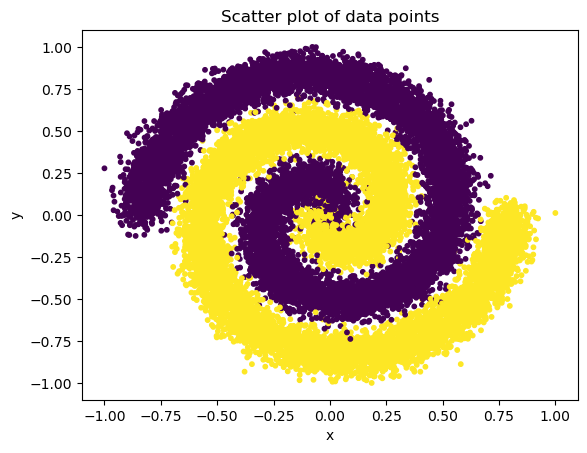

In [24]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=10)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
import torch
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.float32)

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


In [26]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)
sgd_val_losses = []

# # Early stopping 변수
# min_val_loss = float('inf')
# patience = 100
# steps_no_improvement = 0
# min_step = 0

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(50000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  

  if steps % 10 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    sgd_val_losses.append(val_loss.item())

    # # Early stopping 적용(val_loss가 개선되지 않으면 patience만큼 기다린 후 학습 중지)
    # if val_loss < min_val_loss:
    #   min_val_loss = val_loss
    #   steps_no_improvement = 0
    #   min_step = steps
    # else:
    #   steps_no_improvement += 1
    #   if steps_no_improvement == patience:
    #     print(f"Early stopping at step {steps} with min_val_loss: {min_val_loss.item()}")
    #     break

    output = net(train_data)
    train_loss = loss_fn(output, train_labels)
    if steps % 1000 == 0:
      print(f"{steps} val_loss: {val_loss.item()}, train_loss: {train_loss.item()}")


0 val_loss: 0.6951403617858887, train_loss: 0.6962078213691711
1000 val_loss: 0.6916131377220154, train_loss: 0.6913983821868896
2000 val_loss: 0.6891796588897705, train_loss: 0.6888722777366638
3000 val_loss: 0.6829337477684021, train_loss: 0.682271420955658
4000 val_loss: 0.6671044230461121, train_loss: 0.6656609773635864
5000 val_loss: 0.6484845876693726, train_loss: 0.6459429264068604
6000 val_loss: 0.6374170780181885, train_loss: 0.6338410973548889
7000 val_loss: 0.6289548277854919, train_loss: 0.6249554753303528
8000 val_loss: 0.6199846267700195, train_loss: 0.6153055429458618
9000 val_loss: 0.6038526296615601, train_loss: 0.5984063148498535
10000 val_loss: 0.5774194598197937, train_loss: 0.5702510476112366
11000 val_loss: 0.5457779765129089, train_loss: 0.5366898775100708
12000 val_loss: 0.5233768820762634, train_loss: 0.5135912895202637
13000 val_loss: 0.5091387629508972, train_loss: 0.49873295426368713
14000 val_loss: 0.4987950026988983, train_loss: 0.4877716302871704
15000 va

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, hidden_size),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  

net = Net(2, 16, 1)
adam_val_losses = []

# Early stopping 변수
# min_val_loss = float('inf')
# patience = 100
# steps_no_improvement = 0
# min_step = 0

loss_fn = nn.BCEWithLogitsLoss()
# Adam optimizer로 변경
optimizer = optim.Adam(net.parameters(), lr=0.01)

for steps in range(50000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  loss = loss_fn(output, label_batch)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  

  if steps % 10 == 0:
    net.eval()
    output = net(val_data)
    val_loss = loss_fn(output, val_labels)
    adam_val_losses.append(val_loss.item())

    # # Early stopping 적용(val_loss가 개선되지 않으면 patience만큼 기다린 후 학습 중지)
    # if val_loss < min_val_loss:
    #   min_val_loss = val_loss
    #   steps_no_improvement = 0
    #   min_step = steps
    # else:
    #   steps_no_improvement += 1
    #   if steps_no_improvement == patience:
    #     print(f"Early stopping at step {steps} with min_val_loss: {min_val_loss.item()}")
    #     break

    output = net(train_data)
    train_loss = loss_fn(output, train_labels)
    if steps % 1000 == 0:
      print(f"{steps} val_loss: {val_loss.item()}, train_loss: {train_loss.item()}")


0 val_loss: 0.6927855610847473, train_loss: 0.6934109926223755
1000 val_loss: 0.062614805996418, train_loss: 0.06581327319145203
2000 val_loss: 0.04027470573782921, train_loss: 0.04184085503220558
3000 val_loss: 0.032967761158943176, train_loss: 0.036596741527318954
4000 val_loss: 0.03934082016348839, train_loss: 0.044185981154441833
5000 val_loss: 0.036698706448078156, train_loss: 0.038738399744033813
6000 val_loss: 0.04390498995780945, train_loss: 0.036476217210292816
7000 val_loss: 0.03196730464696884, train_loss: 0.03335241600871086
8000 val_loss: 0.035207729786634445, train_loss: 0.0332474485039711
9000 val_loss: 0.031370628625154495, train_loss: 0.03186116740107536
10000 val_loss: 0.03232736885547638, train_loss: 0.03559671714901924
11000 val_loss: 0.03742165118455887, train_loss: 0.03570321574807167
12000 val_loss: 0.0407925620675087, train_loss: 0.04121788591146469
13000 val_loss: 0.03920130804181099, train_loss: 0.04169277101755142
14000 val_loss: 0.0337083674967289, train_los

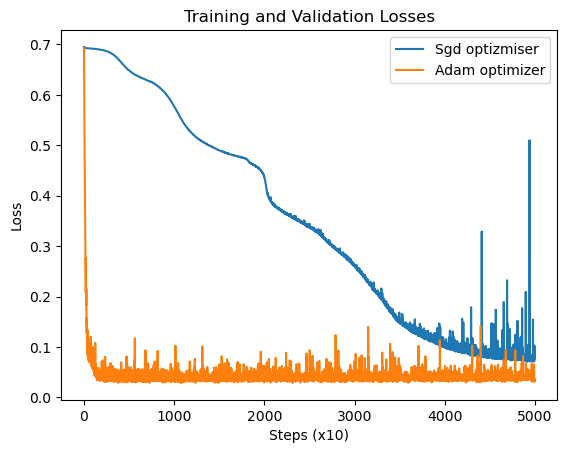

In [30]:
import matplotlib.pyplot as plt

plt.plot(sgd_val_losses, label='Sgd optizmiser')
plt.plot(adam_val_losses, label='Adam optimizer')

plt.title('Training and Validation Losses')
plt.xlabel('Steps (x10)')
plt.ylabel('Loss')
plt.legend()

plt.show()